<a href="https://colab.research.google.com/github/vicentbas/ia3_uv/blob/main/ecg_full_dataframe_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---
# Trabajo evaluación bloque 2: Clasificador de electrocardiogramas mediante LSTM

#<strong><center> ECG analyzer </strong>

El objetivo del siguiente proyecto es crear un clasificador de electrocardiogramas, capaz de diferencias entre estudios patológicos y estudios normales. Como entrada al proyecto se utilzan ficheros XML exportados desde el sistema Philips IntelliSpace ECG B.00.02 en formato XML FDA para electrocardiografos de 12 derivaciones.

In [ ]:
from xml.dom import minidom
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Input, Concatenate, GlobalMaxPooling1D, BatchNormalization, Activation, TimeDistributed, Conv1D, MaxPooling1D, Dropout, LeakyReLU, GlobalAveragePooling1D, Flatten, ReLU
from keras.optimizers import Adam
from tensorflow import keras

import glob
import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
import json 

np.random.seed(7)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
ruta_base = "/content/drive/MyDrive/Kaggle/ptb-ecg/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install wfdb wget

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def equalizer(Y):
  #'CD', 'HYP', 'MI', 'NORM', 'STTC'
  CD = Y[Y['diagnostic_superclass'] == 'CD'].count()['diagnostic_superclass']
  HYP = Y[Y['diagnostic_superclass'] == 'HYP'].count()['diagnostic_superclass']
  MI = Y[Y['diagnostic_superclass'] == 'MI'].count()['diagnostic_superclass']
  NORM = Y[Y['diagnostic_superclass'] == 'NORM'].count()['diagnostic_superclass']
  STTC = Y[Y['diagnostic_superclass'] == 'STTC'].count()['diagnostic_superclass']
  min = np.amin(np.array([CD,HYP,MI,NORM,STTC]))

  t1 = Y[Y['diagnostic_superclass'] == 'CD'][:min]
  t2 = Y[Y['diagnostic_superclass'] == 'HYP'][:min]
  t3 = Y[Y['diagnostic_superclass'] == 'MI'][:min]
  t4 = Y[Y['diagnostic_superclass'] == 'NORM'][:min]
  t5 = Y[Y['diagnostic_superclass'] == 'STTC'][:min]

  return pd.concat([t1, t2, t3, t4, t5], ignore_index=True)

In [ ]:
import ast
import wfdb
path = ruta_base
sampling_rate=500
input_size=sampling_rate * 10
n_muestras = 20000
 
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id', nrows=n_muestras)
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
 
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
 
def aggregate_diagnostic(y_dic):
    tmp = ""
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp = agg_df.loc[key].diagnostic_class
            break
    return tmp
 
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
 
Y = Y[Y['diagnostic_superclass'] != '']
 
Y = equalizer(Y)
 
y = np.array(Y.diagnostic_superclass)

In [ ]:
if sampling_rate == 100:
    data = [wfdb.rdsamp(path+f) for f in Y.filename_lr]
else:
    data = [wfdb.rdsamp(path+f) for f in Y.filename_hr]
data = np.array([signal for signal, meta in data])

X = data

# Ploting sample leads

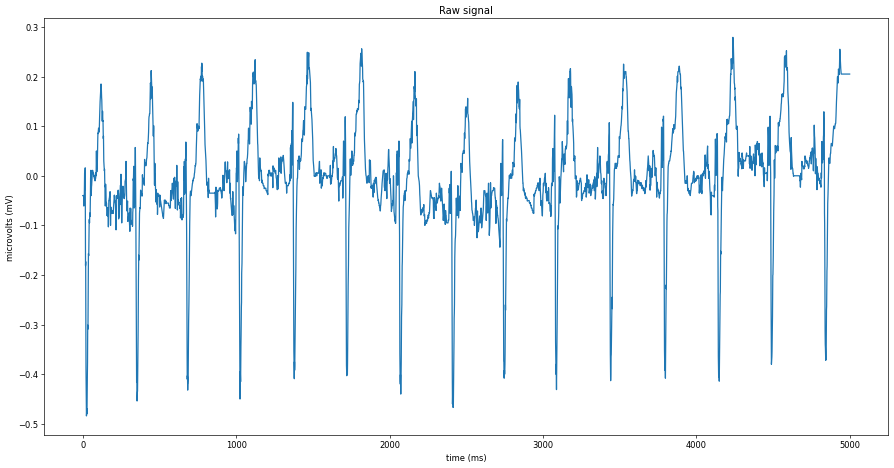

In [ ]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(X[3][:,0])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (mV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

In [ ]:
size = 12 * input_size
X_ = X.reshape(X.shape[0],size)
scaler = preprocessing.MinMaxScaler()
X_  = scaler.fit_transform(X_)
X_ = X_.reshape(X.shape[0],input_size,12)

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y)
y_ = le.transform(y)
from keras.utils import np_utils
uniques, ids = np.unique(y_, return_inverse=True)
y_ = np_utils.to_categorical(ids, len(uniques))

In [ ]:
def reverse_transform(array_val):
  return le.inverse_transform(uniques[array_val.argmax(1)])

In [ ]:
np.unique(y)

array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object)

In [ ]:
categories = len(np.unique(y))

# Modelo 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_,y_, test_size=0.4, random_state=42)

In [ ]:
np.unique(reverse_transform(y_train), return_counts=True)

(array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object),
 array([683, 720, 730, 716, 718]))

In [ ]:
np.unique(reverse_transform(y_test), return_counts=True)

(array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object),
 array([506, 469, 459, 473, 471]))

In [ ]:
input = Input((input_size,12))
ecg_model = Dropout(rate=0.7)(input)
ecg_model = Conv1D(64,kernel_size=13,strides=6)(input)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=7,strides=4)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = Conv1D(256,kernel_size=3,strides=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)

model = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

    

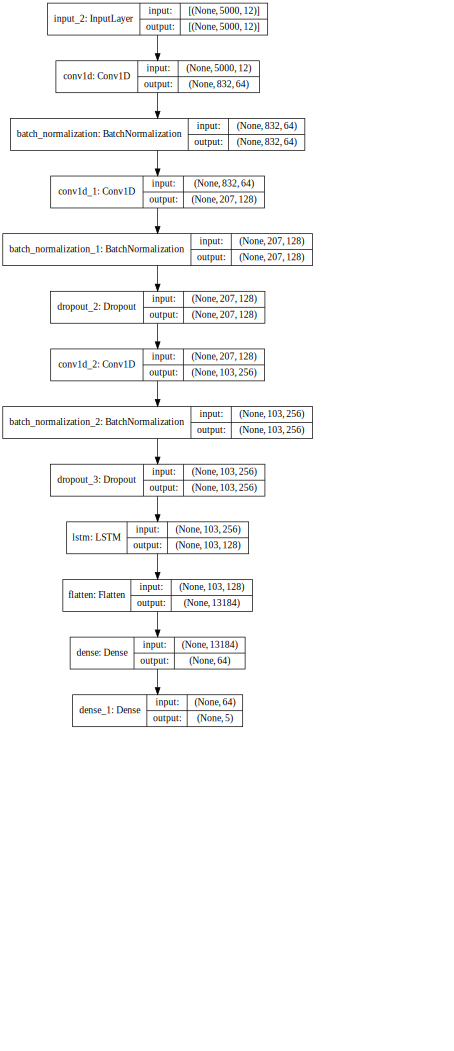

In [ ]:
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot
display(SVG(model_to_dot(model, show_shapes=True, dpi=50).create(prog='dot', format='svg')))

In [ ]:
history6 = model.fit(X_train,y_train, epochs=200,verbose=1, validation_data=(X_test,y_test))

Epoch 1/50
37/37 [==============================] - 19s 38ms/step - loss: 1.6473 - accuracy: 0.1997 - val_loss: 1.6118 - val_accuracy: 0.1997
Epoch 2/50
37/37 [==============================] - 1s 20ms/step - loss: 1.5887 - accuracy: 0.2534 - val_loss: 1.6129 - val_accuracy: 0.2088
Epoch 3/50
37/37 [==============================] - 1s 19ms/step - loss: 1.5881 - accuracy: 0.2675 - val_loss: 1.6429 - val_accuracy: 0.1830
Epoch 4/50
37/37 [==============================] - 1s 19ms/step - loss: 1.5584 - accuracy: 0.3066 - val_loss: 1.7392 - val_accuracy: 0.1830
Epoch 5/50
37/37 [==============================] - 1s 20ms/step - loss: 1.5194 - accuracy: 0.3351 - val_loss: 1.9435 - val_accuracy: 0.1791
Epoch 6/50
37/37 [==============================] - 1s 19ms/step - loss: 1.4296 - accuracy: 0.4452 - val_loss: 2.2932 - val_accuracy: 0.1817
Epoch 7/50
37/37 [==============================] - 1s 19ms/step - loss: 1.3930 - accuracy: 0.3933 - val_loss: 2.6483 - val_accuracy: 0.1791
Epoch 8/50
3

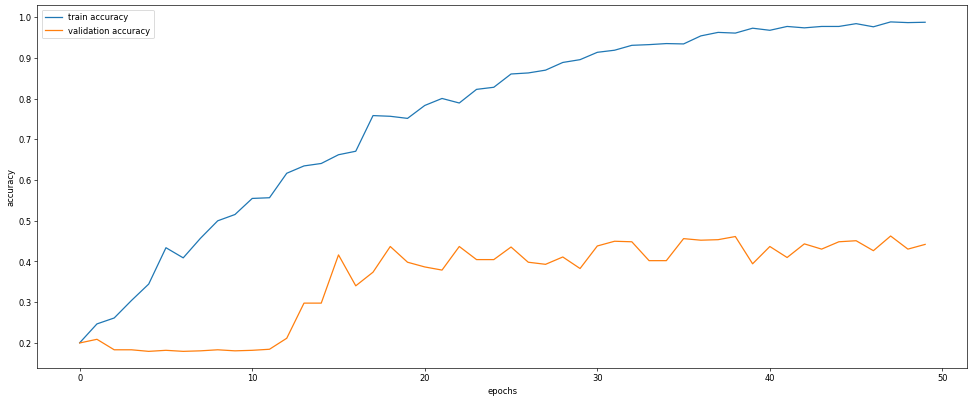

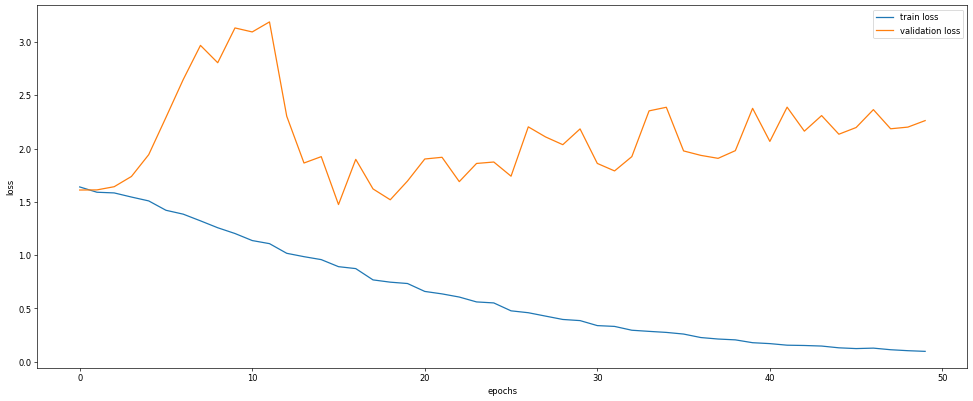

In [ ]:
plt.figure(figsize=(20,8), dpi= 60)
plt.plot(history6.history['accuracy'],label='train accuracy')
plt.plot(history6.history['val_accuracy'],label='validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

plt.figure(figsize=(20,8), dpi= 60)
plt.plot(history6.history['loss'],label='train loss')
plt.plot(history6.history['val_loss'],label='validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

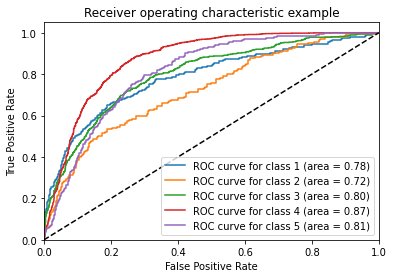

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model.predict(X_test)

  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Modelo 2

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_,y_, test_size=0.4, random_state=42)

input = Input((input_size,12))
ecg_model = Conv1D(64,kernel_size=21,strides=11)(input)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = LeakyReLU(alpha=0.1)(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = Conv1D(64,kernel_size=7,strides=1)(ecg_model)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=5,strides=1)(ecg_model)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = Conv1D(256,kernel_size=13,strides=1)(ecg_model)
ecg_model = Conv1D(512,kernel_size=7,strides=1)(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = Conv1D(256,kernel_size=9,strides=1)(ecg_model)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = LSTM(128, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(categories, activation='softmax')(ecg_model)

model2 = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0001)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

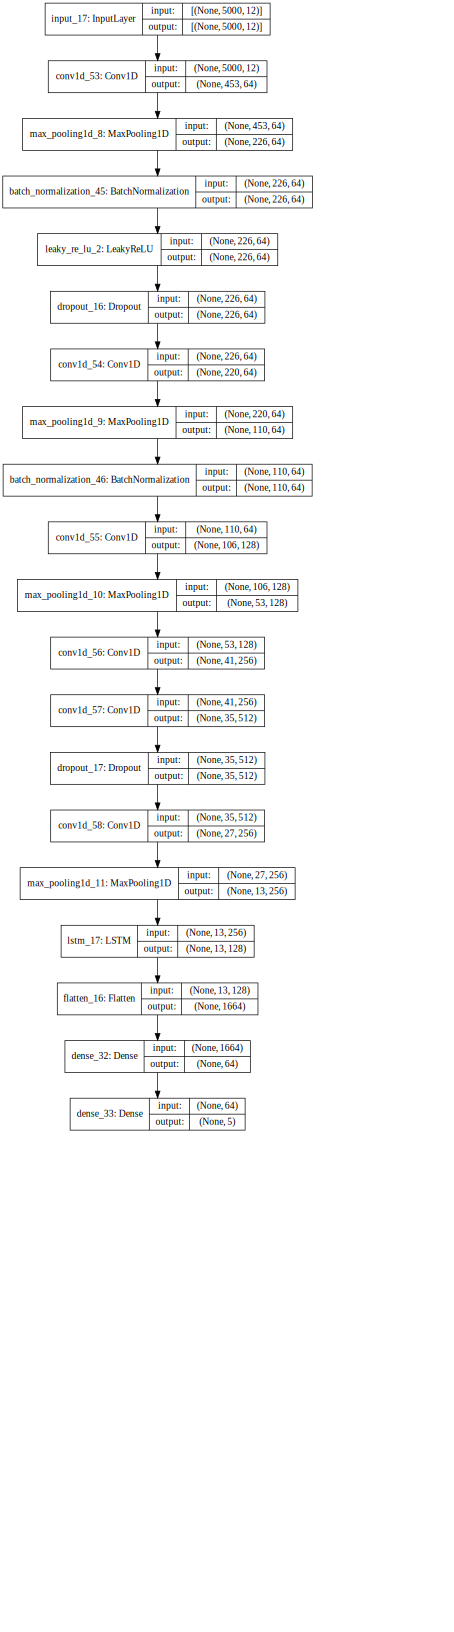

In [ ]:
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot
display(SVG(model_to_dot(model2, show_shapes=True, dpi=50).create(prog='dot', format='svg')))

In [ ]:
history7 = model2.fit(X_train,y_train, epochs=50,verbose=1, validation_data=(X_test,y_test))

Epoch 1/50
130/130 [==============================] - 5s 22ms/step - loss: 1.3300 - accuracy: 0.5048 - val_loss: 1.4127 - val_accuracy: 0.5047
Epoch 2/50
130/130 [==============================] - 2s 16ms/step - loss: 1.1960 - accuracy: 0.5508 - val_loss: 1.4504 - val_accuracy: 0.5047
Epoch 3/50
130/130 [==============================] - 2s 16ms/step - loss: 1.1477 - accuracy: 0.5650 - val_loss: 1.4385 - val_accuracy: 0.5051
Epoch 4/50
130/130 [==============================] - 2s 16ms/step - loss: 1.0955 - accuracy: 0.5878 - val_loss: 1.3348 - val_accuracy: 0.5644
Epoch 5/50
130/130 [==============================] - 2s 16ms/step - loss: 1.0680 - accuracy: 0.6067 - val_loss: 1.4062 - val_accuracy: 0.5174
Epoch 6/50
130/130 [==============================] - 2s 16ms/step - loss: 1.0206 - accuracy: 0.6035 - val_loss: 1.4146 - val_accuracy: 0.5362
Epoch 7/50
130/130 [==============================] - 2s 16ms/step - loss: 0.9396 - accuracy: 0.6311 - val_loss: 1.4626 - val_accuracy: 0.5372

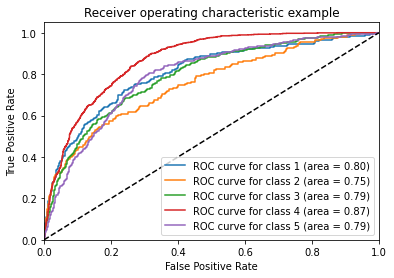

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(categories):
  from sklearn.metrics import roc_curve, roc_auc_score, auc
  y_pred_keras = model2.predict(X_test)

  fpr[i], tpr[i], _  = roc_curve(y_test[:, i], y_pred_keras[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(categories):
  plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (area = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()